El método de Bolsa de Palabras desarrollado antes tiene ciertas desventajas conocidas:
* Muy costoso computacionalmente.
* Lo más importante: no guarda información sonbre el *contexto* de cada palabra en el texto, así como su relación con las palabras cercanas.

Con un método más avanzado de **Word Embedding** como *Word2Vec* esperamos mejorar tanto la eficiencia del modelo como sus resultados prácticos. (Averiguar: BOW es también Word Embedding? Qué algoritmo usa Fasttext específicamente?)

Usaremos la librería **Fasttext** para constuir el modelo, en lugar de Scikit. Pero afortunadamente, el código anterior aún se puede reutilizar; de las 3 partes en las que se divide, aún podemos usar la primera (recopilcación de datos) y la última (testeo con Scikit).

La primera diferencia a tener en cuenta es que para ajustar los hiperparámetros en Fasttext nos conviene tener un tercer conjunto, de validación (o "dev"), además de train y test. Vamos a mantener el 80% de train, pero los otros 2 los separamos en 10% cada uno.

In [6]:
from filterTools import csvFilter
from dataTools import build_chats, total_chats, filter_chats, filter_classes, split_chats
import json

# Recopilación de datos

## Formato de fecha que usamos
dt_format = '%Y-%m-%d %H:%M:%S.%f'

## Leemos las tablas que tenemos
discs = csvFilter('db/discussions.csv')
msgs = csvFilter('db/messages.csv')

## Creamos las conversaciones y las organizamos en un diccionario
## En este ya estan clasificadas por ejercicio
all_chats = build_chats(discs, msgs, dt_format)
print(f'Conversaciones totales: {total_chats(all_chats)}')

# Etapa de filtros
max_length = 5000
min_ex = 10
train_percent = 80 # %
dev_percent = 0 # %

## Funcion que filtra las conversaciones (pueden agregarse mas cosas aqui)
def chat_filter(chat):
    return len(chat) <= max_length

## Funcion que filtra las clases (pueden agregarse mas cosas aqui)
def ex_filter(chats):
    return len(chats) >= min_ex

## Filtramos en orden (importante)
filtered_chats = filter_chats(all_chats, chat_filter)
print(f'\nConversaciones tras filtros individuales: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

filtered_chats = filter_classes(filtered_chats, ex_filter)
print(f'\nConversaciones tras filtros de clase: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

## Creamos un diccionario para cada subconjunto y separamos equilibradamente (de acuerdo al % elegido)
(train_chats, test_chats, dev_chats) = split_chats(filtered_chats, train_percent, dev_percent)
filtered_chats.clear()

print(f'\nConversaciones para entrenamiento: {total_chats(train_chats)}')
print(f'Conversaciones para test: {total_chats(test_chats)}')
if dev_percent > 0:
    print(f'Conversaciones para validación: {total_chats(dev_chats)}')

## Convertimos a json y los escribimos en archivos separados
with open('data/train_chats.json', 'w', encoding='utf-8') as f1:
    json.dump(train_chats, f1)
print('\nConjunto de entrenamiento guardado!')
train_chats.clear()

with open('data/test_chats.json', 'w', encoding='utf-8') as f2:
    json.dump(test_chats, f2)
print('Conjunto de test guardado!')
test_chats.clear()

if dev_percent > 0:
    with open('data/dev_chats.json', 'w', encoding='utf-8') as f3:
        json.dump(dev_chats, f3)
    print('Conjunto de validación guardado!')
    dev_chats.clear()

Conversaciones totales: 14266

Conversaciones tras filtros individuales: 14159
Ejercicios totales: 109

Conversaciones tras filtros de clase: 14006
Ejercicios totales: 73

Conversaciones para entrenamiento: 11208
Conversaciones para test: 2798

Conjunto de entrenamiento guardado!
Conjunto de test guardado!


Antes, Scikit se ocupaba del preprocesamiento del texto y la clasificación, mientras que el tokenizado intermedio lo hacía Scikit. Ahora, Fasttext se ocupa de la clasificación, pero aún se puede beneficiar del tokenizado (y preprocesamiento) de Spacy; de otra forma, Fasttext separará las "palabras" de acuerdo a espacios vacíos (lo cual sabemos que es demasiado "simple" para texto real). Lo que hacemos entonces es tokenizar con Scikit y después representar el resultado de cada texto con espacios intermedios (similar a como hacíamos en una conversación *antes* de tokenizar) para que Fasttext lo interprete. Antes de cada lista de palabras, tiene que estar el prefijo __label__{clase} donde "clase" será el número del ejercicio.

Para instalar Fasttext, simplemente:
```
pip install fasttext
```

Separaremos el proceso en 2 partes muy simples:
* Procesamos el texto con Spacy y generamos nuevos archivos para usar en Fasttext.
* Creamos el clasificador (y lo entrenamos).

In [1]:
import json
from dataTools import separate_classes, clean_text, normalize_chats, vocabulary_builder, separate_classes
import spacy as sp

lowercase = True
remove_spaces = True
remove_punctuation = False
translate_emojis = True
rem_rep_chars = True

# Recuperación de los datos guardados
with open('data/train_chats.json', 'r', encoding='utf-8') as f1:
    train_chats = json.load(f1)
print('Conjunto de entrenamiento cargado')

with open('data/test_chats.json', 'r', encoding='utf-8') as f2:
    test_chats = json.load(f2)
print('Conjunto de test cargado')

dev_chats = {}
try:
    with open('data/dev_chats.json', 'r', encoding='utf-8') as f3:
        dev_chats = json.load(f3)
    print('Conjunto de validación cargado')
except IOError:
    print('No hay conjunto de validación!')

## Función para procesar cada conversación con Spacy.
nlp = sp.load('es_core_news_sm')
def tokenizer(text):
    tokens = nlp(text)
    return [token.text for token in tokens]

## Funcion de preprocesamiento.
def preprocess(text):
    return clean_text(text, lowercase=lowercase, remove_spaces=remove_spaces, remove_punctuation=remove_punctuation, translate_emojis=translate_emojis, rem_rep_chars=rem_rep_chars)

## Extra: buscar las palabras menos frecuentes.
full_vocab = vocabulary_builder(separate_classes(train_chats)[0] + separate_classes(test_chats)[0] + separate_classes(dev_chats)[0], count=True, preprocess=preprocess)
infrequent = [word for word in full_vocab['words'].keys() if full_vocab['words'][word] < 3]
print(f'\nTokens poco frecuentes: {len(infrequent)}')

## Funcion para reemplazar las palabras menos frecuentes (debe hacerse sobre arreglos, y no sobre textos!)
def remove_infrequent(text_arr):
    for i, word in enumerate(text_arr):
        if word in infrequent:
            text_arr[i] = 'UNKNOWN'
    return text_arr

## Separamos los chats de sus clases (etiquetas) y generamos los archivos de Fasttext
normalize_chats(separate_classes(train_chats), 'data/w2v/train_chats_ft.txt', tokenizer, preprocess, remove_infrequent)
print('\nConjunto de entrenamiento procesado y guardado')
normalize_chats(separate_classes(test_chats), 'data/w2v/test_chats_ft.txt', tokenizer, preprocess, remove_infrequent)
print('Conjunto de test procesado y guardado')
if dev_chats is not None:
    normalize_chats(separate_classes(dev_chats), 'data/w2v/dev_chats_ft.txt', tokenizer, preprocess, remove_infrequent)
    print('Conjunto de validación procesado y guardado')

c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Conjunto de entrenamiento cargado
Conjunto de test cargado
No hay conjunto de validación!

Tokens poco frecuentes: 18777

Conjunto de entrenamiento procesado y guardado
Conjunto de test procesado y guardado
Conjunto de validación procesado y guardado


Usamos una función separada para entrenar (aunque por el momento no la puedo usar en Windows!)

Los parámetros básicos que debemos considerar son el *learning rate* y el número de épocas, pero además tenemos:
* *wordNgrams*, para trabajar con bloques de más de 1 palabra (token)
* El tamaño de la "ventana" alrededor de cada bloque que debe considerarse como contexto
* El ritmo en el que el *learning rate* disminuye

El conjunto de validación sólo lo usamos para buscar los parámetros automáticamente; si no lo hacemos, nos convendría reservar un conjunto de test más grande. Además de guardar el modelo entrenado, podemos guardar el resultado de las predicciones sobre el conjunto de test, de la forma **[clase correcta] [predicción]**, para seguir usando las métricas de Scikit.

In [ ]:
import ft_train_and_test as ft_train

ft_train.model_train('data/w2v/train_chats_ft.txt', 'models/w2v/model.bin', 'data/w2v/test_chats_ft.txt', lr=0.8, epoch=1000, wordNgrams=1, ws=7, lrUpdateRate=150, dim=200, out_test='data/w2v/ft_test_predictions.txt')

Predicciones cargadas

METRICAS
              precision    recall  f1-score   support

       13291       0.00      0.00      0.00         2
       13292       1.00      1.00      1.00         2
       13297       0.67      0.67      0.67         3
       13299       0.00      0.00      0.00         3
       13305       1.00      0.33      0.50         3
       13306       0.00      0.00      0.00         6
       13307       0.00      0.00      0.00         2
       13308       0.00      0.00      0.00         3
       13309       0.00      0.00      0.00         5
       13319       0.00      0.00      0.00         2
       13320       0.80      0.80      0.80         5
       13323       0.50      0.33      0.40         3
       13908       0.00      0.00      0.00         2
        2736       0.78      0.74      0.76        38
        2738       0.73      0.79      0.76        42
        2740       0.79      0.82      0.80       118
        2750       0.69      0.81      0.75      

c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


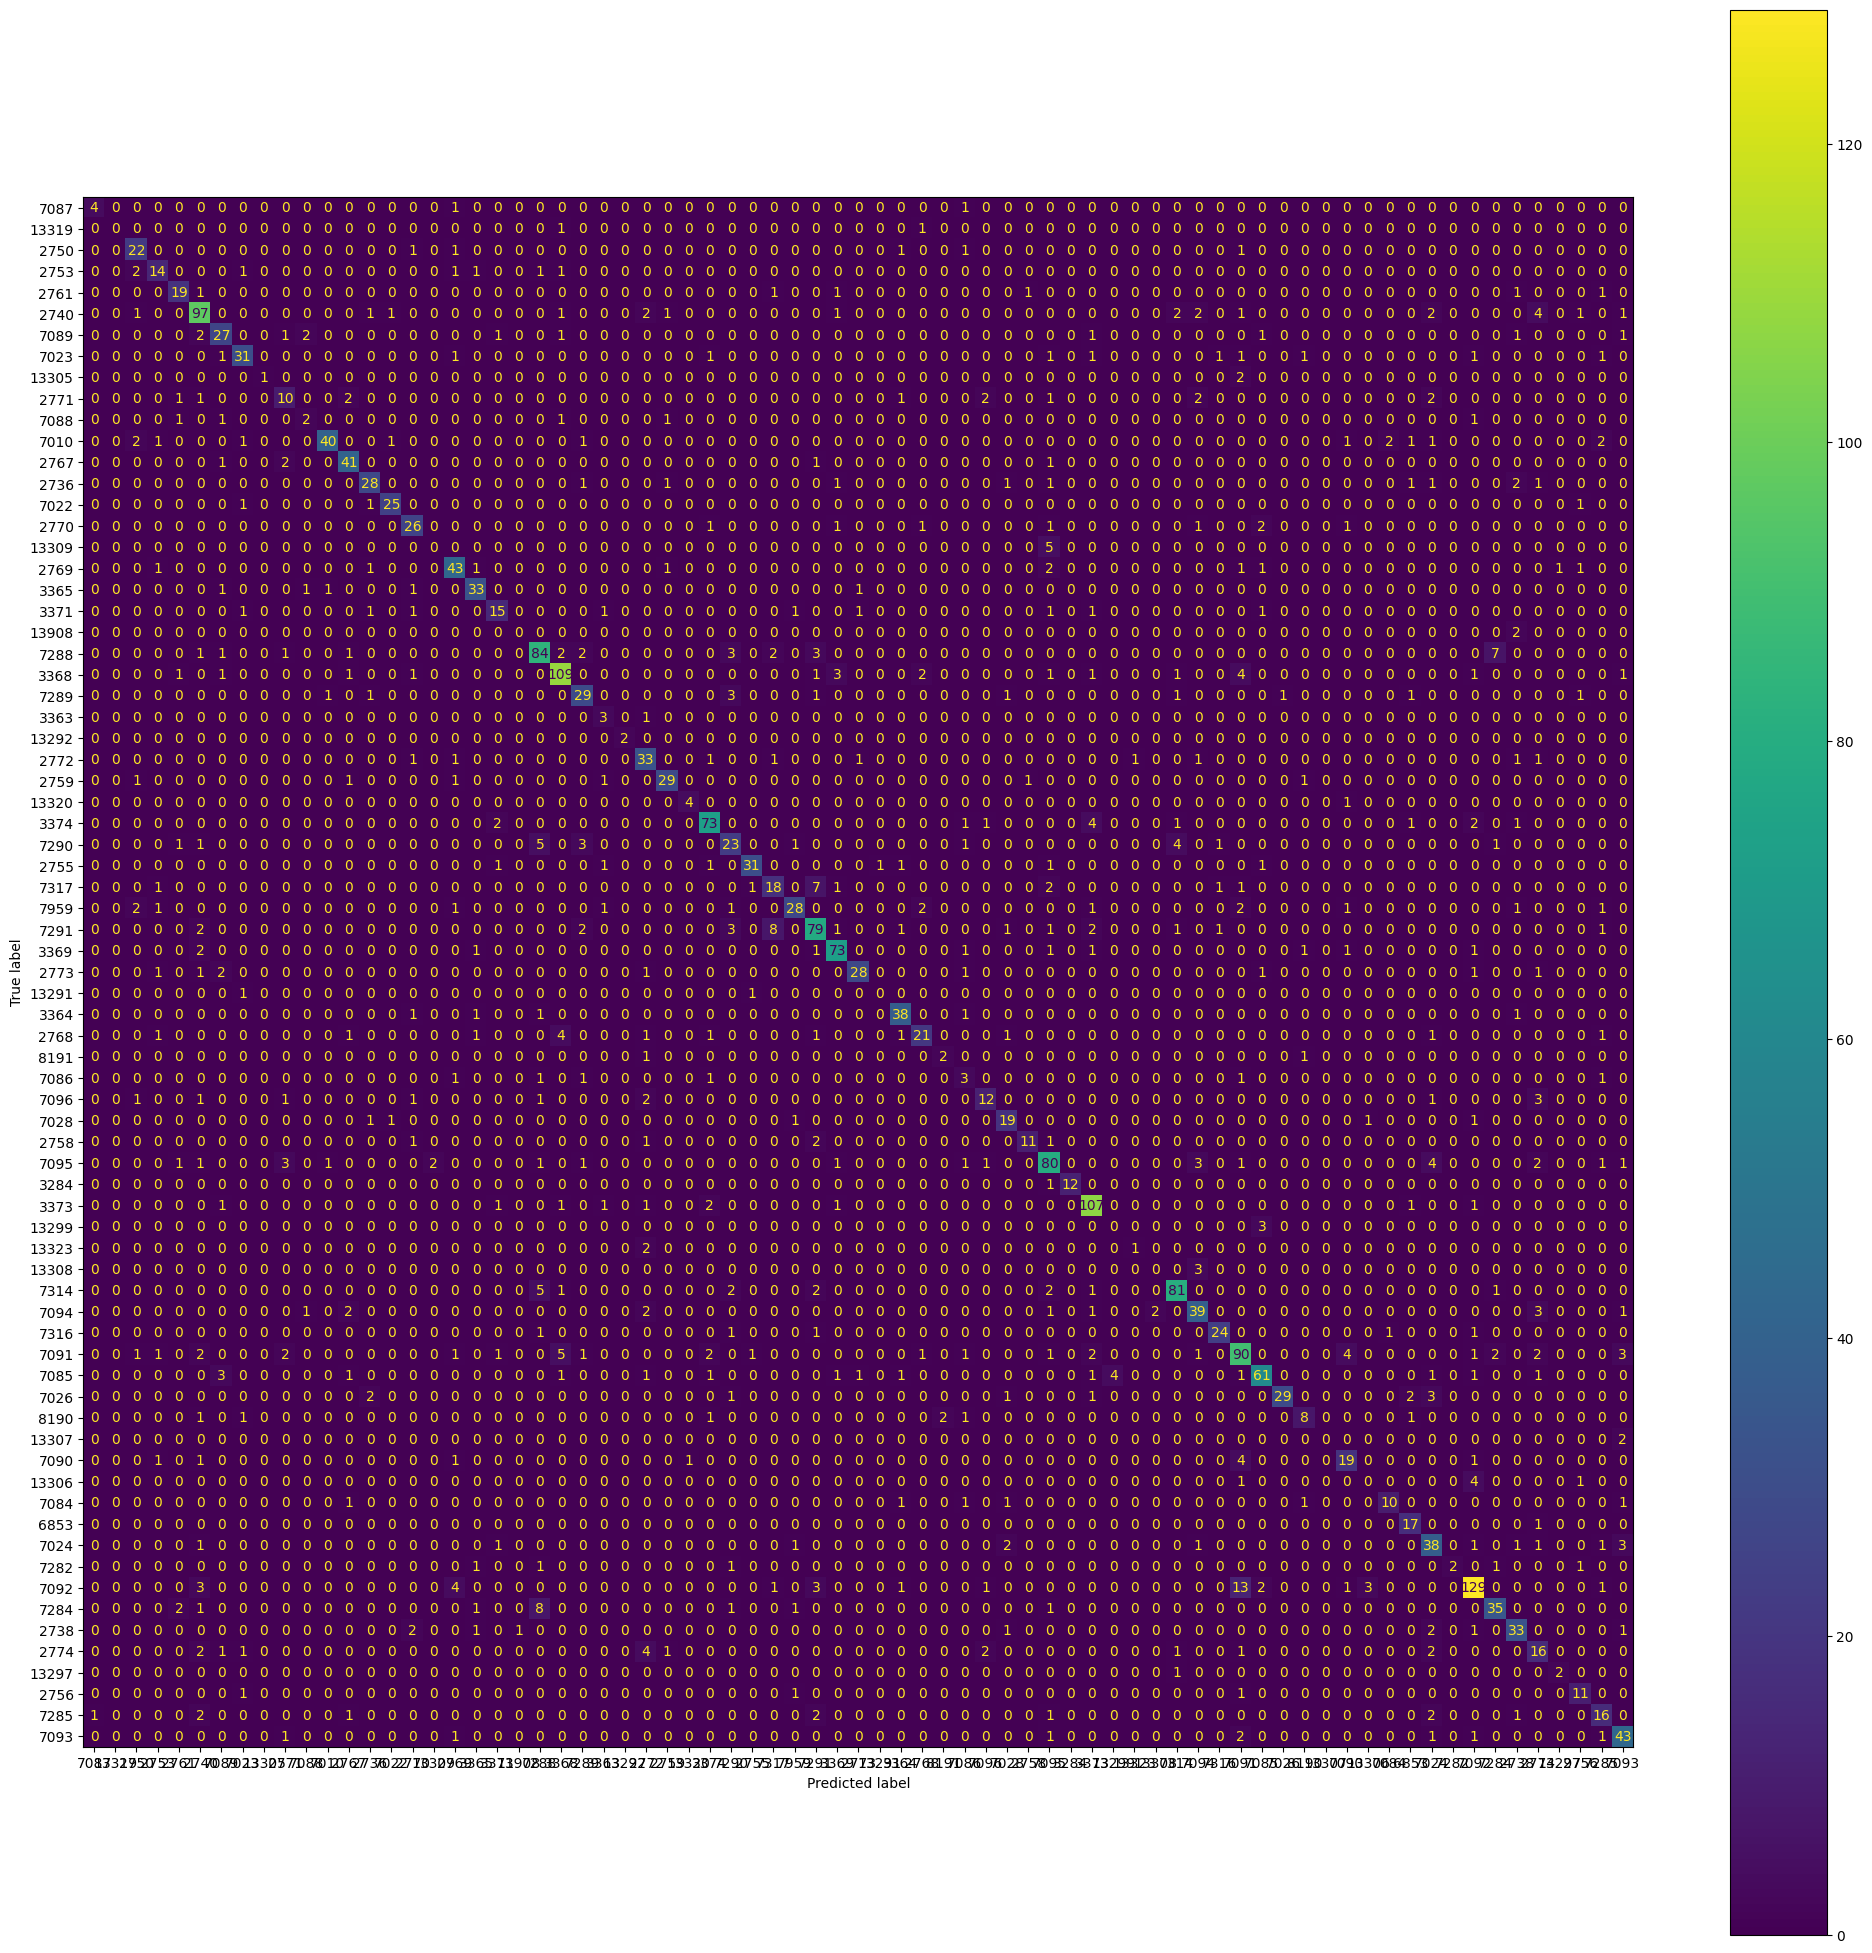

In [3]:
from sklearn import metrics

# Recuperación de las predicciones guardadas
test_results = {'true_values': [], 'predictions': []}
with open('data/w2v/ft_test_predictions.txt', 'r', encoding='utf-8') as preds:
    for line in preds:
        pred = line.replace('\n', '').split(' ')
        test_results['true_values'].append(pred[0])
        test_results['predictions'].append(pred[1])
print('Predicciones cargadas')


# Etapa de tests
labels = list(set(test_results["true_values"]))
print('\nMETRICAS')
print(metrics.classification_report(test_results["true_values"], test_results["predictions"], zero_division=0))
print(f'\nAccuracy: {metrics.accuracy_score(test_results["true_values"], test_results["predictions"])}')
print(f'Balanced accuracy: {metrics.balanced_accuracy_score(test_results["true_values"], test_results["predictions"])}')
print(f'Precision: {metrics.precision_score(test_results["true_values"], test_results["predictions"], labels=labels, average="weighted")}')
print(f'Recall: {metrics.recall_score(test_results["true_values"], test_results["predictions"], labels=labels, average="weighted")}')
print(f'F1: {metrics.f1_score(test_results["true_values"], test_results["predictions"], labels=labels, average="weighted")}')
print('Confusion Matrix')
cmatrix = metrics.ConfusionMatrixDisplay.from_predictions(test_results["true_values"], test_results["predictions"], labels=labels)
fig = cmatrix.figure_
fig.set_figwidth(25)
fig.set_figheight(25)

Tareas nuevas:
* Completar el documento de métricas
* Separar mensajes de estudiantes y tutores, calcular el vocabulario de cada uno
* Ver cuántos mensajes de tutores incluyen código (en markdown)
* Probar de eliminar el código y recalcular los modelos

En lugar de volver al capítulo anterior, separamos discusiones/mensajes de estudiantes/tutores y aplicamos la tokenización anterior (luego de los filtros), obteniendo estadísticas nuevas

In [8]:
from filterTools import csvFilter
import re

tutors = csvFilter('db/messages.csv', lambda msg: msg['from_moderator'] == 'True', saveField='sender_uid')
print(f'Tutores: {len(tutors)}')

tut_msgs = csvFilter('db/messages.csv', lambda msg: msg['sender_uid'] in tutors, write=True, tag='-tutors')
print(f'\nMensajes de tutores: {len(tut_msgs)}')
stud_msgs = csvFilter('db/messages.csv', lambda msg: msg['sender_uid'] not in tutors, write=True, tag='-students')
print(f'Mensajes de estudiantes: {len(stud_msgs)}')

tut_discs_ids = csvFilter('db/messages-tutors.csv', saveField='discussion_id')
tut_discs = csvFilter('db/discussions.csv', lambda disc: disc['id'] in tut_discs_ids, write=True, tag='-tutors')
print(f'\nDiscusiones con algún mensaje de tutor: {len(tut_discs)}')
stud_discs = csvFilter('db/discussions.csv', lambda disc: disc['id'] not in tut_discs_ids, write=True, tag='-students')
print(f'Discusiones sin ningún mensaje de tutor: {len(stud_discs)}')

tut_code_msgs = csvFilter('db/messages-tutors.csv', lambda msg: re.search(r'```.*```', msg['content'], flags=re.DOTALL))
print(f'\nMensajes de tutores con código (en Mardown): {len(tut_code_msgs)}')
stud_code_msgs = csvFilter('db/messages-students.csv', lambda msg: re.search(r'```.*```', msg['content'], flags=re.DOTALL))
stud_code_discs = csvFilter('db/discussions.csv', lambda disc: re.search(r'```.*```', disc['description'], flags=re.DOTALL))
print(f'Mensajes de estudiantes con código (en Mardown): {len(stud_code_msgs) + len(stud_code_discs)}')

Tutores: 23

Mensajes de tutores: 13844
Mensajes de estudiantes: 14592

Discusiones con algún mensaje de tutor: 12103
Discusiones sin ningún mensaje de tutor: 2163

Mensajes de tutores con código (en Mardown): 4357
Mensajes de estudiantes con código (en Mardown): 139


In [1]:
from filterTools import csvFilter
from dataTools import vocabulary_builder, clean_text

tut_msgs_content = [msg['content'] for msg in csvFilter('db/messages-tutors.csv')]
tut_vocab = vocabulary_builder(tut_msgs_content, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'Vocabulario de tutores: {tut_vocab["total_vocab"]}')
print(f'Vocabulario de tutores con frecuencia < 3: {len([word for word, frec in tut_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de tutores: {tut_vocab["total"]}')

stud_msgs_content = [msg['content'] for msg in csvFilter('db/messages-students.csv')]
stud_discs_content = [disc['description'] for disc in csvFilter('db/discussions.csv', lambda disc: disc['description'])]
stud_vocab = vocabulary_builder(stud_msgs_content + stud_discs_content, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de estudiantes: {stud_vocab["total_vocab"]}')
print(f'Vocabulario de estudiantes con frecuencia < 3: {len([word for word, frec in stud_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de estudiantes: {stud_vocab["total"]}')

msgs_content = [msg['content'] for msg in csvFilter('db/messages.csv')]
discs_content = [disc['description'] for disc in csvFilter('db/discussions.csv', lambda disc: disc['description'])]
vocab = vocabulary_builder(msgs_content + discs_content, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario total: {vocab["total_vocab"]}')
print(f'Vocabulario total con frecuencia < 3: {len([word for word, frec in vocab["words"].items() if frec < 3])}')
print(f'Total de tokens: {vocab["total"]}')

Vocabulario de tutores: 18896
Vocabulario de tutores con frecuencia < 3: 10055
Total de tokens de tutores: 2340863

Vocabulario de estudiantes: 22873
Vocabulario de estudiantes con frecuencia < 3: 14901
Total de tokens de estudiantes: 1037704

Vocabulario total: 32122
Vocabulario total con frecuencia < 3: 19560
Total de tokens: 3378567


In [2]:
from filterTools import csvFilter
from dataTools import vocabulary_builder, clean_text
import re

def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

tut_msgs_content = [filter_md(msg['content']) for msg in csvFilter('db/messages-tutors.csv')]
tut_vocab = vocabulary_builder(tut_msgs_content, count=True,preprocess=lambda t: clean_text(t, lowercase=True))
print(f'Vocabulario de tutores quitando código (en Markdown): {tut_vocab["total_vocab"]}')
print(f'Vocabulario de tutores quitando código con frecuencia < 3: {len([word for word, frec in tut_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de tutores quitando código (en Markdown): {tut_vocab["total"]}')

stud_msgs_content = [filter_md(msg['content']) for msg in csvFilter('db/messages-students.csv')]
stud_discs_content = [filter_md(disc['description']) for disc in csvFilter('db/discussions.csv', lambda disc: disc['description'])]
stud_vocab = vocabulary_builder(stud_msgs_content + stud_discs_content, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de estudiantes quitando código (en Markdown): {stud_vocab["total_vocab"]}')
print(f'Vocabulario de estudiantes quitando código con frecuencia < 3: {len([word for word, frec in stud_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de estudiantes quitando código (en Markdown): {stud_vocab["total"]}')

msgs_content = [filter_md(msg['content']) for msg in csvFilter('db/messages.csv')]
discs_content = [filter_md(disc['description']) for disc in csvFilter('db/discussions.csv', lambda disc: disc['description'])]
vocab = vocabulary_builder(msgs_content + discs_content, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario total quitando código (en Markdown): {vocab["total_vocab"]}')
print(f'Vocabulario total quitando código con frecuencia < 3: {len([word for word, frec in vocab["words"].items() if frec < 3])}')
print(f'Total de tokens quitando código (en Markdown): {vocab["total"]}')

Vocabulario de tutores quitando código (en Markdown): 15601
Vocabulario de tutores quitando código con frecuencia < 3: 8001
Total de tokens de tutores quitando código (en Markdown): 1902011

Vocabulario de estudiantes quitando código (en Markdown): 22724
Vocabulario de estudiantes quitando código con frecuencia < 3: 14795
Total de tokens de estudiantes quitando código (en Markdown): 1028683

Vocabulario total quitando código (en Markdown): 29416
Vocabulario total quitando código con frecuencia < 3: 17853
Total de tokens quitando código (en Markdown): 2930694


Para hacer lo mismo sobre el conjunto de entrenamiento, primero hay que construir las conversaciones (y filtrarlas)

In [1]:
from filterTools import csvFilter
from dataTools import build_chats, filter_chats, filter_classes, split_chats, separate_classes, vocabulary_builder, clean_text
import re

max_length = 5000
min_ex = 10
train_percent = 80 # %

def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

discs = csvFilter('db/discussions.csv')
msgs = csvFilter('db/messages.csv')
tut_discs = csvFilter('db/discussions-tutors.csv')
stud_discs = csvFilter('db/discussions-students.csv')

## Funcion que filtra las conversaciones (pueden agregarse mas cosas aqui)
def chat_filter(chat):
    return len(chat) <= max_length

## Funcion que filtra las clases (pueden agregarse mas cosas aqui)
def ex_filter(chats):
    return len(chats) >= min_ex

## Construimos y filtramos (x2) en 1 linea
all_chats = filter_classes(filter_chats(build_chats(discs, msgs), chat_filter), ex_filter)
tut_chats = filter_classes(filter_chats(build_chats(tut_discs, msgs), chat_filter), ex_filter)
stud_chats = filter_classes(filter_chats(build_chats(stud_discs, msgs), chat_filter), ex_filter)

## Separamos el conjunto de entrenamiento y obtenemos el arreglo de textos en 1 linea
all_chats_texts = separate_classes(split_chats(all_chats, train_percent)[0])[0]
tut_chats_texts = separate_classes(split_chats(tut_chats, train_percent)[0])[0]
stud_chats_texts = separate_classes(split_chats(stud_chats, train_percent)[0])[0]

## Calculamos vocabularios
vocab = vocabulary_builder(all_chats_texts, count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'Vocabulario total: {vocab["total_vocab"]}')
print(f'Vocabulario total con frecuencia < 3: {len([word for word, frec in vocab["words"].items() if frec < 3])}')
print(f'Total de tokens: {vocab["total"]}')
tut_vocab = vocabulary_builder(tut_chats_texts, count=True,preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de discusiones con tutores: {tut_vocab["total_vocab"]}')
print(f'Vocabulario de discusiones con tutores con frecuencia < 3: {len([word for word, frec in tut_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de discusiones con tutores: {tut_vocab["total"]}')
stud_vocab = vocabulary_builder(stud_chats_texts, count=True,preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de discusiones con estudiantes: {stud_vocab["total_vocab"]}')
print(f'Vocabulario de discusiones con estudiantes con frecuencia < 3: {len([word for word, frec in stud_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de discusiones con estudiantes: {stud_vocab["total"]}')

## Ahora quitando el código
vocab = vocabulary_builder([filter_md(chat) for chat in all_chats_texts], count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario total quitando código (en Markdown): {vocab["total_vocab"]}')
print(f'Vocabulario total quitando código con frecuencia < 3: {len([word for word, frec in vocab["words"].items() if frec < 3])}')
print(f'Total de tokens quitando código (en Markdown): {vocab["total"]}')
tut_vocab = vocabulary_builder([filter_md(chat) for chat in tut_chats_texts], count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de discusiones con tutores quitando código (en Markdown): {tut_vocab["total_vocab"]}')
print(f'Vocabulario de discusiones con tutores quitando código con frecuencia < 3: {len([word for word, frec in tut_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de discusiones con tutores quitando código (en Markdown): {tut_vocab["total"]}')
stud_vocab = vocabulary_builder([filter_md(chat) for chat in stud_chats_texts], count=True, preprocess=lambda t: clean_text(t, lowercase=True))
print(f'\nVocabulario de discusiones con estudiantes quitando código (en Markdown): {stud_vocab["total_vocab"]}')
print(f'Vocabulario de discusiones con estudiantes quitando código con frecuencia < 3: {len([word for word, frec in stud_vocab["words"].items() if frec < 3])}')
print(f'Total de tokens de discusiones con estudiantes quitando código (en Markdown): {stud_vocab["total"]}')

Vocabulario total: 27542
Vocabulario total con frecuencia < 3: 16630
Total de tokens: 2544540

Vocabulario de discusiones con tutores: 24633
Vocabulario de discusiones con tutores con frecuencia < 3: 14531
Total de tokens de discusiones con tutores: 2293096

Vocabulario de discusiones con estudiantes: 10010
Vocabulario de discusiones con estudiantes con frecuencia < 3: 6511
Total de tokens de discusiones con estudiantes: 243254

Vocabulario total quitando código (en Markdown): 25144
Vocabulario total quitando código con frecuencia < 3: 15093
Total de tokens quitando código (en Markdown): 2192719

Vocabulario de discusiones con tutores quitando código (en Markdown): 22231
Vocabulario de discusiones con tutores quitando código con frecuencia < 3: 12989
Total de tokens de discusiones con tutores quitando código (en Markdown): 1950313

Vocabulario de discusiones con estudiantes quitando código (en Markdown): 9857
Vocabulario de discusiones con estudiantes quitando código con frecuencia < 3

Observamos que remover el código en Markdown disminuye nuestra precisión. Lo siqguiente que queremos probar para mejorar el modelo es quitar las palabras con frecuencia < 3. Como vimos, estas constituyen el 60% del vocabulario, pero en volumen total, no superan el 1,3%. Las podemos quitar poor completo o reemplazar por un término especial. No obstante, antes de eso debemos calcular el vocabulario - lo cual nos hace tokenizar 2 veces!